# Das Bechdel test

Lots of people have studied the effects of the Bechdel test on movies: in particular <a href="https://fivethirtyeight.com/tag/bechdel-test/">several articles on fivethirtyeight.com</a> and <a href="http://www.brianckeegan.com/2014/04/the-need-for-openness-in-data-journalism/">an article by Brian Keegan extending 538's work</a>. These are some notes from my own exploration of the topic. Maybe to be turned into a blog post or paper.

As I reminder, the Bechdel test is way of evaluating movie scripts on their representation of women. It says: "There are two women and they talk to each other about something other than a man." That seems like a ridiculously low bar, but still at least 40% of movies fail it.

## Getting the data

First, some preliminaries (importing needed Python packages). Then, load the data. Let's assume here that I did that data-ing correctly. See scripts numbered 1 through 6 to see how I got to this point.

If you are looking at this through a Jupyter notebook interface, you can run the Code block below by clicking on it and pressing Shift-Enter. It should result in a message that says "Dataset loaded".

In [53]:
#from itertools import product
#from matplotlib.collections import LineCollection
#import statsmodels.formula.api as smf
import numpy as np
import scipy
from matplotlib import pyplot as plt
from IPython.display import Image, display, HTML
import pandas as pd
import datetime as datetime
import warnings
warnings.filterwarnings('ignore')
movies_df = pd.read_csv('movies_for_analysis.csv',encoding='utf-8',index_col='imdb_id')
movies_df['released'] = pd.to_datetime(movies_df['released'])
print('Dataset loaded')

Dataset loaded


## Choosing a study sample

Next question: what movies are in?

### Whose movies?

The Bechdel test was invented to discuss Hollywood movies, which is a slightly vague and nebulous term. Ideally we would want to consider releases from "major Hollywood studios," but that is hard to define. This is because of the "Fox Searchlight problem." Fox Searchlight is a subsidiary of Fox that distributes foreign films. Should they be considered as a part of 20th Century Fox, or not?

Even if that were easy to define, it would still be hard to put into code, because there are so damn many studios represented. Run the code block below to see just how many.

In [50]:
display(HTML('<p>The number of unique studios in our dataset (remember, not yet cut on time), according to two sources:'))

#movies_df.columns
nStudiosIMDb = len(movies_df.groupby('studio'))  # studio data from IMDb
nStudiosBOM = len(movies_df.groupby('studio_boxofficemojo')) # studio data from boxofficemojo.com (as of May 2017)

print('Number of studios according to IMDb: {0:,.0f}'.format(nStudiosIMDb))
print('Number of studios according to Box Office Mojo: {0:,.0f}'.format(nStudiosBOM))
print('(Those lists certainly overlap)')

Number of studios according to IMDb: 1,374
Number of studios according to Box Office Mojo: 202
(Those lists certainly overlap)


So let's try a different approach that is certainly not perfect, but will get us closer to where we want to be: consider only movies made in the US (the value for "country" from OMDb includes 'usa').

In [55]:
#print('Number of movies before: {:,.0f}'.format(len(movies_df)))
movies_df = movies_df[movies_df['usa'] == 1]
print('Selected only movies made in the United States.')
#print('Number of movies after: {:,.0f}'.format(len(movies_df)))

Selected only movies made in the United States.


### Movies from when?

Assuming we have appropriately selected "Hollywood movies" as our object of study, "Hollywood" means something very different now than it did many years ago. We are interested mostly in the Hollywood of today, but we do also want to look back a bit to see if the situation has changed. Eliminating the very oldest movies will serve another purpose also: we know that our dataset is less complete for the earliest years, so this eliminates a possible source of bias.

So we want to look back into the past, but not too far into the past - but when exactly is our cutoff for which movies to include? I picked 1969, which was the first full year in which MPAA ratings had replaced the Hays Code. That seems like as good a place as any to draw a line between "Old Hollywood" and "Modern Hollywood."

If you'd like to draw that line at a different point instead, change the value of <code>firstyear</code> in the very first line of the Code block below, then rerun everything below that point.

In [61]:
firstyear = 1969
movies_df = movies_df[movies_df['bechdel_year'] >= firstyear]
print('Selected only movies released since {:.0f}.'.format(firstyear))

Selected only movies released since 1969.


Cool, so how many movies does that leave us with? And how many do we have complete data for?

Our dataset is such that every movie included has a Bechdel test result, but not every movie has financial data. Run the next Code block to see how many movies we are dealing with.

In [64]:
display(HTML('<h3>Number of movies in our study sample</h3>'.format(firstyear)))

print('Total number of movies: {:,.0f}'.format(len(movies_df)))
print('Movies with Bechdel test results: {:,.0f}'.format(len(movies_df[~pd.isnull(movies_df['bechdel_rating'])])))
print('')
print('Movies with box office receipt data: {:,.0f}'.format(len(movies_df[~pd.isnull(movies_df['boxoffice_adj'])])))
print('Movies with budget, profit, and ROI data: {:,.0f}'.format(len(movies_df[~pd.isnull(movies_df['profit_adj'])])))

Total number of movies: 4,252
Movies with Bechdel test results: 4,252

Movies with box office receipt data: 3,486
Movies with budget, profit, and ROI data: 2,409


It's hard to find sample sizes for either the 538 study or Keegan's study (I'll see if I can find them laters), I'm pretty sure ours is the largest study of this kind ever undertaken.

w00t!

## Whyfore art thou, Bechdel?
### (AKA are we using the right methodology to answer our questions?)

So now we know which movies are in for our study, and which are out. Next up: considering whether the Bechdel test is even a useful way to understand the representation of women in movies.

I have my doubts, and maybe we can come up with a better metric later &mdash; but for now, the Bechdel test seems like the only game in town, so let's roll with it.

Next question: how do we treat the Bechdel test? Because it's a three-part test, so you could easily imagine scoring it: zero points if there are one or zero women, one point if there are 2+ but they don't talk to each other, two points if they talk about a man, and three points for a full pass. I'll consider that in an appendix here. But I think it's more in line with the original purpose of the test to consider it as a hard pass/fail. That has another advantage: having only two (ordered) categories makes our analysis easier to undertake, interpret, and explain.

In [66]:
# Create a new variable called 'bechdel_passed': 1 for films that pass the test, 0 for films that fail.
movies_df['bechdel_passed'] = np.where(movies_df['bechdel_rating'] == 3, 1, 0)
display(HTML('<p>Created new variable with hard pass/fail Bechdel test results: <code>bechdel_passed</code></p>'))

Which movies pass or fail the Bechdel test? As I said, I'm not entirely sure the Bechdel test is the right metric for measuring the representation of <a href='https://www.youtube.com/watch?v=KCjMZMxNr-0'>women in film</a>.

Let's look at a few movies and apply some common sense check whether we think the Bechdel test is a legit way of looking at the representation of women (in stats lingo: testing for <em>face validity</em>). Run the code block below to see some movies that both fail and pass the Bechdel test. For both failures and passes, the code shows three randomly chosen movies followed by the five highest-grossing movies. They are displayed in a table. The last column of each table has a follow-able link to that movie's entry on the Bechdel test site, so you can see the text from the original submitter explaining why s/he scored that movie the way s/he did.

Run the Code block below. Read the four lists of movies and ask yourself (to put it somewhat necessarily bluntly): Do I buy it?

In [81]:
display(HTML('<h3>Movies that fail the Bechdel test</h3>'))

display(HTML('<h4>Three randomly-chosen movies that fail the Bechdel test:</h4>'))
random_failers = movies_df.dropna()[['title','bechdel_year','boxoffice_adj','bechdel_site_id']][movies_df['bechdel_passed'] == 0].sample(3).sort_values(['bechdel_year','title']).values.tolist()

# Surely there is an easier way to print a pandas dataframe as a well-formatted table?
#### Maybe by sending a dictionary of styles to .style.format()? Halp?
#### But anyway, this kinda-hacky code does what needs doing.
y = '<table>'
y += '<tr>'
y += '<th>Title</th>'
y += '<th>Year</th>'
y += '<th>Box office (Dec-2016 $)</th>'
y += '<th>Link</th>'
y += '</tr>'
for row in random_failers:
    link = 'http://www.bechdeltest.com/view/'+str(row[3])
    link_str = '<a href=\''+link+'\' target="_blank">'+link+'</a>'
    y += '<tr>'
    y += '<td>{:}</td>'.format(row[0])
    y += '<td>{:.0f}</td>'.format(row[1])
    y += '<td style="text-align:right">${:,.0f}</td>'.format(row[2])
    y += '<td>{:}</td>'.format(link_str)
    y += '</tr>'
y += '</table>'
display(HTML(y))

display(HTML('<h4>The five highest-grossing movies that fail the Bechdel test:</h2>'))
highest_failers = movies_df[['title','bechdel_year','boxoffice_adj','bechdel_site_id']][movies_df['bechdel_passed'] == 0].sort_values('boxoffice_adj',ascending=False).head(5).values.tolist()

y = '<table>'
y += '<tr>'
y += '<th>Title</th>'
y += '<th>Year</th>'
y += '<th>Box office (Dec-2016 $)</th>'
y += '<th>Link</th>'
y += '</tr>'
for row in highest_failers:
    link = 'http://www.bechdeltest.com/view/'+str(row[3])
    link_str = '<a href=\''+link+'\' target="_blank">'+link+'</a>'
    y += '<tr>'
    y += '<td>{:}</td>'.format(row[0])
    y += '<td>{:.0f}</td>'.format(row[1])
    y += '<td style="text-align:right">${:,.0f}</td>'.format(row[2])
    y += '<td>{:}</td>'.format(link_str)
    y += '</tr>'
y += '</table>'
display(HTML(y))

display(HTML('<h3>Movies that pass the Bechdel test</h3>'))

display(HTML('<h4>Three randomly-chosen movies that pass the Bechdel test:</h4>'))
random_passers = movies_df.dropna()[['title','bechdel_year','boxoffice_adj','bechdel_site_id']][movies_df['bechdel_passed'] == 1].sample(3).sort_values(['bechdel_year','title']).values.tolist()

# Surely there is an easier way to print a pandas dataframe as a well-formatted table?
#### Maybe by sending a dictionary of styles to .style.format()? Halp?
#### But anyway, this kinda-hacky code does what needs doing.
y = '<table>'
y += '<tr>'
y += '<th>Title</th>'
y += '<th>Year</th>'
y += '<th>Box office (Dec-2016 $)</th>'
y += '<th>Link</th>'
y += '</tr>'
for row in random_passers:
    link = 'http://www.bechdeltest.com/view/'+str(row[3])
    link_str = '<a href=\''+link+'\' target="_blank">'+link+'</a>'
    y += '<tr>'
    y += '<td>{:}</td>'.format(row[0])
    y += '<td>{:.0f}</td>'.format(row[1])
    y += '<td style="text-align:right">${:,.0f}</td>'.format(row[2])
    y += '<td>{:}</td>'.format(link_str)
    y += '</tr>'
y += '</table>'
display(HTML(y))

display(HTML('<h4>The five highest-grossing movies that pass the Bechdel test:</h2>'))
highest_passers = movies_df[['title','bechdel_year','boxoffice_adj','bechdel_site_id']][movies_df['bechdel_passed'] == 1].sort_values('boxoffice_adj',ascending=False).head(5).values.tolist()

y = '<table>'
y += '<tr>'
y += '<th>Title</th>'
y += '<th>Year</th>'
y += '<th>Box office (Dec-2016 $)</th>'
y += '<th>Link</th>'
y += '</tr>'
for row in highest_passers:
    link = 'http://www.bechdeltest.com/view/'+str(row[3])
    link_str = '<a href=\''+link+'\' target="_blank">'+link+'</a>'
    y += '<tr>'
    y += '<td>{:}</td>'.format(row[0])
    y += '<td>{:.0f}</td>'.format(row[1])
    y += '<td style="text-align:right">${:,.0f}</td>'.format(row[2])
    y += '<td>{:}</td>'.format(link_str)
    y += '</tr>'
y += '</table>'
display(HTML(y))

Title,Year,Box office (Dec-2016 $),Link
Master and Commander: The Far Side of the World,2003,"$122,909,676",http://www.bechdeltest.com/view/841
"Sessions, The",2012,"$6,264,925",http://www.bechdeltest.com/view/3710
"Interview, The",2014,"$6,278,126",http://www.bechdeltest.com/view/6001


Title,Year,Box office (Dec-2016 $),Link
Star Wars,1977,"$1,845,765,685",http://www.bechdeltest.com/view/669
Star Wars: Episode V - The Empire Strikes Back,1980,"$856,735,206",http://www.bechdeltest.com/view/670
Avatar,2009,"$850,251,110",http://www.bechdeltest.com/view/582
"Sting, The",1973,"$834,123,140",http://www.bechdeltest.com/view/2316
"Godfather, The",1972,"$787,082,380",http://www.bechdeltest.com/view/2224


Title,Year,Box office (Dec-2016 $),Link
You Will Meet a Tall Dark Stranger,2010,"$3,589,683",http://www.bechdeltest.com/view/1518
Spring Breakers,2012,"$14,649,700",http://www.bechdeltest.com/view/3874
Stoker,2013,"$1,766,480",http://www.bechdeltest.com/view/4281


Title,Year,Box office (Dec-2016 $),Link
Jaws,1975,"$1,171,125,373",http://www.bechdeltest.com/view/2561
E.T.: The Extra-Terrestrial,1982,"$1,082,985,683",http://www.bechdeltest.com/view/1645
"Exorcist, The",1973,"$1,057,426,936",http://www.bechdeltest.com/view/751
Titanic,1997,"$985,893,188",http://www.bechdeltest.com/view/345
Star Wars: The Force Awakens,2015,"$956,094,427",http://www.bechdeltest.com/view/6610


For now, it makes more sense to consider the Bechdel test as a straight-up pass/fail test. If a movie features two women talking about something other than a man, it passes the Bechdel test. If not, it fails. Consider "partial pass" later.

In [8]:
movies_df['bechdel_passed'] = np.where((movies_df['bechdel_rating'] == 3), 1, 0)

display(HTML('<h2>Total movies with Bechel test pass/fail results</h2>'))
bechdel_result_table = pd.DataFrame()
bechdel_result_table['nMovies'] = movies_df.groupby('bechdel_passed').size()
bechdel_result_table['result'] = ''
bechdel_result_table['result'] = np.where(bechdel_result_table.index == 0, 'Fail',bechdel_result_table['result'])
bechdel_result_table['result'] = np.where(bechdel_result_table.index == 1, 'Pass',bechdel_result_table['result'])
bechdel_result_table['percentage'] = 100 * (bechdel_result_table['nMovies'] / len(movies_df))
bechdel_result_table[['result','nMovies','percentage']].style.format({'result': '{:10}', 'nMovies': '{:,.0f}', 'percentage': '{0:.0f}%'})
# I made this table again but only with movies that have profit data - percentages are identical.
#bechdel_result_table2['nMovies'] = movies_df[~pd.isnull(movies_df['profit_adj'])].groupby('bechdel_rating').size()

,result,nMovies,percentage
bechdel_passed,,,
0,Fail,"2,480",40%
1,Pass,"3,727",60%


Each year since 1969, an additional 0.45% of movies pass the Bechdel test (r^2 = 0.54).


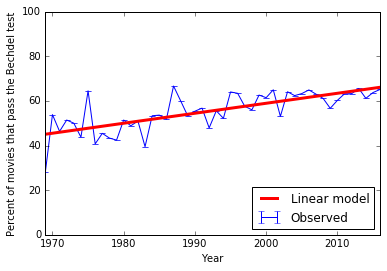

At this rate of increase, all movies will pass the Bechdel test in the year 2092.


In [9]:
#import statsmodels.formula.api as smf
#from scipy import ols
firstyear = 1969 # first year after the Hays code ended
lastyear = 2016 # last full year in dataset
avg_bechdel = movies_df.groupby('bechdel_year')['bechdel_passed'].agg(np.mean)
avg_bechdel.index.name = 'date'
avg_bechdel.name = 'bechdel'
avg_bechdel = avg_bechdel[(avg_bechdel.index >= firstyear) & (avg_bechdel.index <= lastyear)]
avg_bechdel = avg_bechdel.reset_index()
#avg_bechdel

stdevm_bechdel = movies_df.groupby('bechdel_year')['bechdel_passed'].agg(np.std) / movies_df.groupby('bechdel_year')['bechdel_passed'].size()
stdevm_bechdel.index.name = 'date'
stdevm_bechdel.name = 'bechdel'
stdevm_bechdel = stdevm_bechdel[(stdevm_bechdel.index >= firstyear) & (stdevm_bechdel.index <= lastyear)]
stdevm_bechdel = stdevm_bechdel.reset_index()

# multiply both by 100 to express as percentage
avg_bechdel['bechdel'] = avg_bechdel['bechdel'] * 100
#stdevm_bechdel['bechdel'] = stdevm_bechdel['bechdel'] * 100

#errorbarsy = stdevm_bechdel.get_values()

[slope,intercept,rvalue,pvalue,stderr] = linregress(avg_bechdel['date'],avg_bechdel['bechdel'])
#print(slope,intercept,rvalue)
r_squared = rvalue ** 2

print('Each year since {0:.0f}, an additional {1:.2f}% of movies pass the Bechdel test (r^2 = {2:.2f}).'.format(firstyear,slope,r_squared))

predicted = pd.DataFrame({"date": np.linspace(start=1969.,stop=2969.,num=1001)})
predicted['bechdel'] = slope*predicted['date'] + intercept

# Plot the observed data
plt.errorbar(avg_bechdel['date'],avg_bechdel['bechdel'],yerr=stdevm_bechdel['bechdel'],c='b',label='Observed')
# Plot the predictions from the model
plt.plot(predicted['date'],predicted['bechdel'],c='r',label='Linear model',lw=3)
plt.legend(loc='lower right')
plt.ylim((0,100))
plt.xlim((1969,2016))
plt.xlabel('Year')
plt.ylabel('Percent of movies that pass the Bechdel test')
plt.show()
everything_passes_year = predicted['date'].loc[predicted['bechdel'] >= 100].agg(np.min)
print('At this rate of increase, all movies will pass the Bechdel test in the year {0:.0f}.'.format(everything_passes_year))

## Do films that pass the Bechdel test have different budgets than films that fail?

Median budget of films that fail the Bechdel test: $51,537,320.
Median budget of films that pass the Bechdel test: $31,971,396.


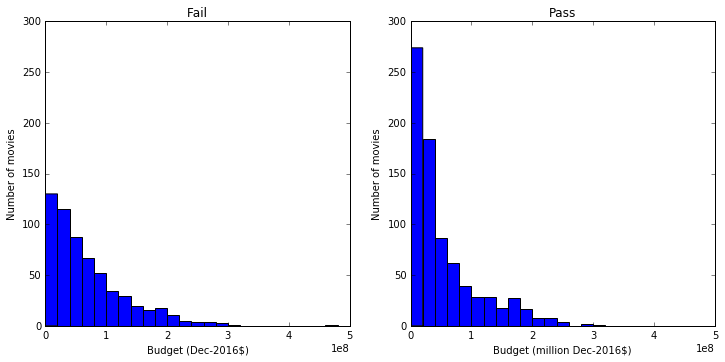

In [10]:
#x = movies_df['bechdel_passed'].apply(lambda x:float(x)+np.random.normal(0, 0.05))
#y = movies_df['budget_adj']
failer_budgets = movies_df.dropna()['budget_adj'][movies_df['bechdel_passed'] == 0]
passer_budgets = movies_df.dropna()['budget_adj'][movies_df['bechdel_passed'] == 1]
#plt.hist(failer_budgets,bins=30)

print('Median budget of films that fail the Bechdel test: ${0:,.0f}.'.format(failer_budgets.agg(np.median)))
print('Median budget of films that pass the Bechdel test: ${0:,.0f}.'.format(passer_budgets.agg(np.median)))

# Calculate best bin widths by Freedman-Draconis rule.
#The bin-width is set to h = 2 * IQR * n^(−1/3).
#So the number of bins is (max−min)/h.

fail_n = len(failer_budgets)
fail_iqr = scipy.stats.iqr(failer_budgets)
fail_binwidth = 2 * fail_iqr * (fail_n ** (-1/3))
fail_bins = (np.max(failer_budgets) - np.min(failer_budgets)) / fail_binwidth

pass_n = len(passer_budgets)
pass_iqr = scipy.stats.iqr(passer_budgets)
pass_binwidth = 2 * pass_iqr * (pass_n ** (-1/3))
pass_bins = (np.max(passer_budgets) - np.min(passer_budgets)) / pass_binwidth

nbins = int(np.round(np.mean([fail_bins,pass_bins]),0))
#print(nbins)

fig = plt.figure(figsize=(12,12))

ax1 = fig.add_subplot(221)
ax1.hist(failer_budgets,bins=nbins,range=(0,500000000))
plt.ylim([0,300])
plt.xlabel('Budget (Dec-2016$)')
plt.ylabel('Number of movies')
plt.title('Fail')

ax2 = fig.add_subplot(222)
ax2.hist(passer_budgets,bins=nbins,range=(0,500000000))
plt.ylim([0,300])
plt.xlabel('Budget (million Dec-2016$)')
plt.ylabel('Number of movies')
plt.title('Pass')

fig.show()


Because budgets vary so widely, it's hard to spot any difference there. Let's try graphing with a log scale for budget.

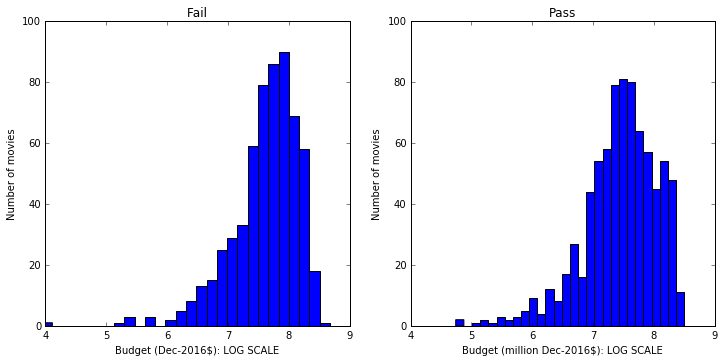

In [12]:
fig = plt.figure(figsize=(12,12))

failer_budgets_logged = np.log10(failer_budgets)
passer_budgets_logged = np.log10(passer_budgets)

faillog_n = len(failer_budgets_logged)
faillog_iqr = scipy.stats.iqr(failer_budgets_logged)
faillog_binwidth = 2 * faillog_iqr * (faillog_n ** (-1/3))
faillog_bins = (np.max(failer_budgets_logged) - np.min(failer_budgets_logged)) / faillog_binwidth

passlog_n = len(passer_budgets_logged)
passlog_iqr = scipy.stats.iqr(passer_budgets_logged)
passlog_binwidth = 2 * passlog_iqr * (passlog_n ** (-1/3))
passlog_bins = (np.max(passer_budgets_logged) - np.min(passer_budgets_logged)) / faillog_binwidth

nbins = int(np.round(np.mean([faillog_bins,passlog_bins]),0))

ax1 = fig.add_subplot(221)
ax1.hist(failer_budgets_logged,bins=nbins)#,range=(0.1,9))
plt.xlim([4,9])
plt.ylim([0,100])
plt.xlabel('Budget (Dec-2016$): LOG SCALE')
plt.ylabel('Number of movies')
plt.title('Fail')

ax2 = fig.add_subplot(222)
ax2.hist(passer_budgets_logged,bins=nbins)#,range=(0,500000000))
plt.xlim([4,9])
plt.ylim([0,100])
plt.xlabel('Budget (million Dec-2016$): LOG SCALE')
plt.ylabel('Number of movies')
plt.title('Pass')

fig.show()


In [11]:
display(HTML('<p>Aside: The five movies made on a budget of $10,000 or less (before inflation adjustment):</p>'))
movies_df[['title','bechdel_year','budget','budget_adj']][movies_df['budget'] <= 10000].sort_values('budget_adj',ascending=True)

,title,bechdel_year,budget,budget_adj
imdb_id,,,,
154506,Following,1998,6000.0,8715.956679
390384,Primer,2004,7000.0,8852.928235
104815,El Mariachi,1992,7000.0,11810.090846
123948,Cure,1997,10000.0,13601.802817
255094,"Circle, The",2000,10000.0,13702.156640


Is the difference in median budgets statistically significant? Use a Mann-Whitney U test to find out.

In [13]:
print('Is the difference in median budgets statistically significant?')
[ustat, pvalue] = scipy.stats.mannwhitneyu(failer_budgets, passer_budgets, use_continuity=True, alternative='two-sided')
if (pvalue < .05):
    print('Yes')
else:
    print('No')
print('p-value: ',pvalue)

display(HTML('<h1>Calculate effect size also!</h1>'))

Is the difference in median budgets statistically significant?
Yes
p-value:  1.34331353462e-09


# PROFITS

Now what about profit?

Min: -191,927,138 Max: 418,412,321
Min: -212,540,529 Max: 643,746,083


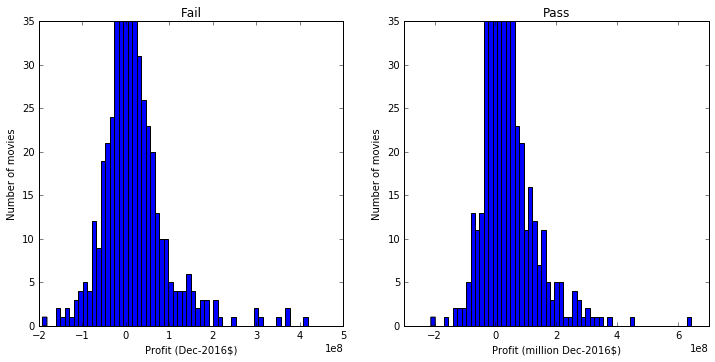

In [29]:
failer_profits = movies_df.dropna()['profit_adj'][movies_df['bechdel_passed'] == 0]
passer_profits = movies_df.dropna()['profit_adj'][movies_df['bechdel_passed'] == 1]

#print('Median profit of films that fail the Bechdel test: ${0:,.0f}.'.format(failer_budgets.agg(np.median)))
#print('Median budget of films that pass the Bechdel test: ${0:,.0f}.'.format(passer_budgets.agg(np.median)))

# Calculate best bin widths by Freedman-Draconis rule.
#The bin-width is set to h = 2 * IQR * n^(−1/3).
#So the number of bins is (max−min)/h.

fail_n = len(failer_profits)
fail_iqr = scipy.stats.iqr(failer_profits)
fail_binwidth = 2 * fail_iqr * (fail_n ** (-1/3))
fail_bins = (np.max(failer_profits) - np.min(failer_profits)) / fail_binwidth
#print(fail_bins)

pass_n = len(passer_profits)
pass_iqr = scipy.stats.iqr(passer_profits)
pass_binwidth = 2 * fail_iqr * (fail_n ** (-1/3))
pass_bins = (np.max(passer_profits) - np.min(passer_profits)) / pass_binwidth
#print(pass_bins)
nbins = int(np.round(np.mean([fail_bins,pass_bins]),0))
#print(nbins)

fig = plt.figure(figsize=(12,12))

ax1 = fig.add_subplot(221)
ax1.hist(failer_profits,bins=nbins)#,range=(-30000000,1000000000))
plt.ylim([0,35])
plt.xlabel('Profit (Dec-2016$)')
plt.ylabel('Number of movies')
plt.title('Fail')

ax2 = fig.add_subplot(222)
ax2.hist(passer_profits,bins=nbins)#,range=(-30000000,1000000000))
plt.ylim([0,35])
plt.xlabel('Profit (million Dec-2016$)')
plt.ylabel('Number of movies')
plt.title('Pass')
print('Min: {0:,.0f} Max: {1:,.0f}'.format(np.min(failer_profits),np.max(failer_profits)))
print('Min: {0:,.0f} Max: {1:,.0f}'.format(np.min(passer_profits),np.max(passer_profits)))
#fig.show()
z  = movies_df[['title','bechdel_year','budget_adj','boxoffice_adj','profit_adj']][movies_df['title'] == 'Star Wars'].values.tolist()

# Below here, I consider "partial pass" results also

In [ ]:
display(HTML('<h2>Total movies with Bechel test results</h2>'))
bechdel_result_table = pd.DataFrame()
bechdel_result_table['nMovies'] = movies_df.groupby('bechdel_rating').size()
bechdel_result_table['result'] = ''
bechdel_result_table['result'] = np.where(bechdel_result_table.index == 0, 'Fewer than two women',bechdel_result_table['result'])
bechdel_result_table['result'] = np.where(bechdel_result_table.index == 1, 'Women don\'t talk',bechdel_result_table['result'])
bechdel_result_table['result'] = np.where(bechdel_result_table.index == 2, 'Women talk about a man',bechdel_result_table['result'])
bechdel_result_table['result'] = np.where(bechdel_result_table.index == 3, 'Passes Bechdel test',bechdel_result_table['result'])
bechdel_result_table['percentage'] = 100 * (bechdel_result_table['nMovies'] / len(movies_df))
bechdel_result_table[['result','nMovies','percentage']].style.format({'result': '{:10}', 'nMovies': '{:,.0f}', 'percentage': '{0:.0f}%'})
# I made this table again but only with movies that have profit data - percentages are identical.
#bechdel_result_table2['nMovies'] = movies_df[~pd.isnull(movies_df['profit_adj'])].groupby('bechdel_rating').size()

We can also estimate a statistical model to forecast future changes in the average Bechdel score over time. We observe a general upward trend in movies passing more of the Bechdel test and can try to extrapolate this going forward.

In [ ]:
#import statsmodels.formula.api as smf
#from scipy import ols
firstyear = 1969 # first year after the Hays code ended
lastyear = 2016 # last full year in dataset
avg_bechdel = movies_df.groupby('bechdel_year')['bechdel_rating'].agg(np.mean)
avg_bechdel.index.name = 'date'
avg_bechdel.name = 'bechdel'
avg_bechdel = avg_bechdel[(avg_bechdel.index >= firstyear) & (avg_bechdel.index <= lastyear)]
avg_bechdel = avg_bechdel.reset_index()
#avg_bechdel

stdevm_bechdel = movies_df.groupby('bechdel_year')['bechdel_rating'].agg(np.std) / movies_df.groupby('bechdel_year')['bechdel_rating'].size()
stdevm_bechdel = stdevm_bechdel[(stdevm_bechdel.index >= firstyear) & (stdevm_bechdel.index <= lastyear)]

errorbarsy = stdevm_bechdel.get_values()

[slope,intercept,rvalue,pvalue,stderr] = linregress(avg_bechdel['date'],avg_bechdel['bechdel'])
#print(slope,intercept,rvalue)
r_squared = rvalue ** 2

print('Regression model: Bechdel test scores have increased by {0:.3f} each year since {1:.0f}, with r^2 = {2:.2f}.'.format(slope,firstyear,r_squared))
predicted = pd.DataFrame({"date": np.linspace(start=1969.,stop=2016.,num=48)})
predicted['bechdel'] = slope*predicted['date'] + intercept

# Plot the observed data
plt.errorbar(avg_bechdel['date'],avg_bechdel['bechdel'],yerr=errorbarsy,c='b',label='Observed')
# Plot the predictions from the model
plt.plot(predicted['date'],predicted['bechdel'],c='r',label='Linear model',lw=3)
plt.legend(loc='lower right')
plt.ylim((0,3))
plt.xlim((1969,2016))
plt.xlabel('Year')
plt.ylabel('Avg. Bechdel Test')
plt.show()

In [ ]:
movies_df['bechdel_passed'] = np.where((movies_df['bechdel_rating'] == 3), 1, 0)

display(HTML('<h2>Total movies with Bechel test pass/fail results</h2>'))
bechdel_result_table = pd.DataFrame()
bechdel_result_table['nMovies'] = movies_df.groupby('bechdel_passed').size()
bechdel_result_table['result'] = ''
bechdel_result_table['result'] = np.where(bechdel_result_table.index == 0, 'Fail',bechdel_result_table['result'])
bechdel_result_table['result'] = np.where(bechdel_result_table.index == 1, 'Pass',bechdel_result_table['result'])
bechdel_result_table['percentage'] = 100 * (bechdel_result_table['nMovies'] / len(movies_df))
bechdel_result_table[['result','nMovies','percentage']].style.format({'result': '{:10}', 'nMovies': '{:,.0f}', 'percentage': '{0:.0f}%'})
# I made this table again but only with movies that have profit data - percentages are identical.
#bechdel_result_table2['nMovies'] = movies_df[~pd.isnull(movies_df['profit_adj'])].groupby('bechdel_rating').size()

In [ ]:
#import statsmodels.formula.api as smf
#from scipy import ols
firstyear = 1969 # first year after the Hays code ended
lastyear = 2016 # last full year in dataset
avg_bechdel = movies_df.groupby('bechdel_year')['bechdel_passed'].agg(np.mean)
avg_bechdel.index.name = 'date'
avg_bechdel.name = 'bechdel'
avg_bechdel = avg_bechdel[(avg_bechdel.index >= firstyear) & (avg_bechdel.index <= lastyear)]
avg_bechdel = avg_bechdel.reset_index()
#avg_bechdel

stdevm_bechdel = movies_df.groupby('bechdel_year')['bechdel_passed'].agg(np.std) / movies_df.groupby('bechdel_year')['bechdel_passed'].size()
stdevm_bechdel.index.name = 'date'
stdevm_bechdel.name = 'bechdel'
stdevm_bechdel = stdevm_bechdel[(stdevm_bechdel.index >= firstyear) & (stdevm_bechdel.index <= lastyear)]
stdevm_bechdel = stdevm_bechdel.reset_index()

# multiply both by 100 to express as percentage
avg_bechdel['bechdel'] = avg_bechdel['bechdel'] * 100
#stdevm_bechdel['bechdel'] = stdevm_bechdel['bechdel'] * 100

#errorbarsy = stdevm_bechdel.get_values()

[slope,intercept,rvalue,pvalue,stderr] = linregress(avg_bechdel['date'],avg_bechdel['bechdel'])
#print(slope,intercept,rvalue)
r_squared = rvalue ** 2

print('Regression model: Each year since {0:.0f}, an additional {1:.2f}% of movies pass the Bechdel test (r^2 = {2:.2f}).'.format(firstyear,slope,r_squared))

predicted = pd.DataFrame({"date": np.linspace(start=1969.,stop=2969.,num=1001)})
predicted['bechdel'] = slope*predicted['date'] + intercept

# Plot the observed data
plt.errorbar(avg_bechdel['date'],avg_bechdel['bechdel'],yerr=stdevm_bechdel['bechdel'],c='b',label='Observed')
# Plot the predictions from the model
plt.plot(predicted['date'],predicted['bechdel'],c='r',label='Linear model',lw=3)
plt.legend(loc='lower right')
plt.ylim((0,100))
plt.xlim((1969,2016))
plt.xlabel('Year')
plt.ylabel('Percent of movies that pass the Bechdel test')
plt.show()
everything_passes_year = predicted['date'].loc[predicted['bechdel'] >= 100].agg(np.min)
print('At this rate of increase, all movies will pass the Bechdel test in the year {0:.0f}.'.format(everything_passes_year))

As I discussed above, the claim that budgets for Bechdel-passing movies is relatively uncontroversial and given the description of the data in the article, should be easy to reproduce. Visualizing the distribution of the data, there are no strong differences that jump out but if you squint hard enough, you can make out a negative trend: movies passing the Bechdel test have lower budgets.

You'll notice each cloud of points around 0, 1, 2, and 3. These are simply "jittered" by adding a bit of normally-distributed errors to the plots (but not the underlying data we're estimating) to show the frequency of datapoints without them all sitting on top of each other.

In [ ]:
x = movies_df['bechdel_rating'].apply(lambda x:float(x)+np.random.normal(0, 0.05))
y = movies_df['budget_adj']

# Plot with an alpha so the overlaps reveal something about relative density
plt.scatter(x,y,alpha=.2,label='Data',c='g')
plt.ylabel('Budgets (Dec-2016 $)',fontsize=18)
plt.xlabel('Bechdel dimensions',fontsize=18)
plt.xticks(np.arange(0,4))
plt.yscale('log')
plt.grid(False,which='minor')
#plt.ylim((2e0,1e10))

We can also visualize the median budgets with a bar chart to see that movies featuring two women who don't talk to each other appear to have much larger budgets than the rest. Movies that pass the Bechdel test also appear to have slightly smaller budgets than movies that don't pass.

In [ ]:
print(groupby)
movies_df['budget_adj'].groupby(movies_df['bechdel_rating']).agg(np.median).plot(kind='barh')
#plt.xticks(range(0,7e7,1e7),range(0,70,10),fontsize=15)
#plt.xticks(range(0e7,7e7,1e7),range(0,70,10),fontsize=15)
plt.xticks(range(0,60000000,10000000),range(0,60,10),fontsize=15)
plt.yticks(plt.yticks()[0],["Fewer than two women",
                             "Women don't talk to each other",
                             'Women only talk about men',
                             'Passes Bechdel Test'
                             ],fontsize=18)
plt.xlabel('Budget (Dec-2016 $millions)',fontsize=18)
plt.title('Median Budget for Films',fontsize=24)
plt.ylabel('')
plt.show()